In [3]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline


In [6]:
df=pd.read_csv('/Downloads/ab_data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
print(f"Total duplicate user_ids: {df['user_id'].duplicated().sum()}")

Total duplicate user_ids: 3894


# Remove duplicates if any  

In [9]:
df = df.drop_duplicates(subset='user_id', keep='first')
print(f"Data shape after removing duplicates: {df.shape}")

Data shape after removing duplicates: (290584, 5)


# Check for inconsistent assignments (where group doesn't match landing_page)

In [11]:
inconsistent_data = df[((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) | 
                      ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]
print(f"Inconsistent assignments (group-landing_page mismatch): {len(inconsistent_data)}")

Inconsistent assignments (group-landing_page mismatch): 2044


#  Remove inconsistent data

In [12]:
df = df[~((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]
df = df[~((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]
print(f"Data shape after removing inconsistent assignments: {df.shape}")

Data shape after removing inconsistent assignments: (288540, 5)


# Exploratory Data Analysis (EDA)

In [13]:
print("\nGroup distribution:")
group_counts = df['group'].value_counts()
print(group_counts)


Group distribution:
treatment    144314
control      144226
Name: group, dtype: int64



Group distribution:
treatment    144314
control      144226
Name: group, dtype: int64

Conversion rates by group:
           conversion_rate  total_visitors  conversions
group                                                  
control           0.120290          144226        17349
treatment         0.118727          144314        17134


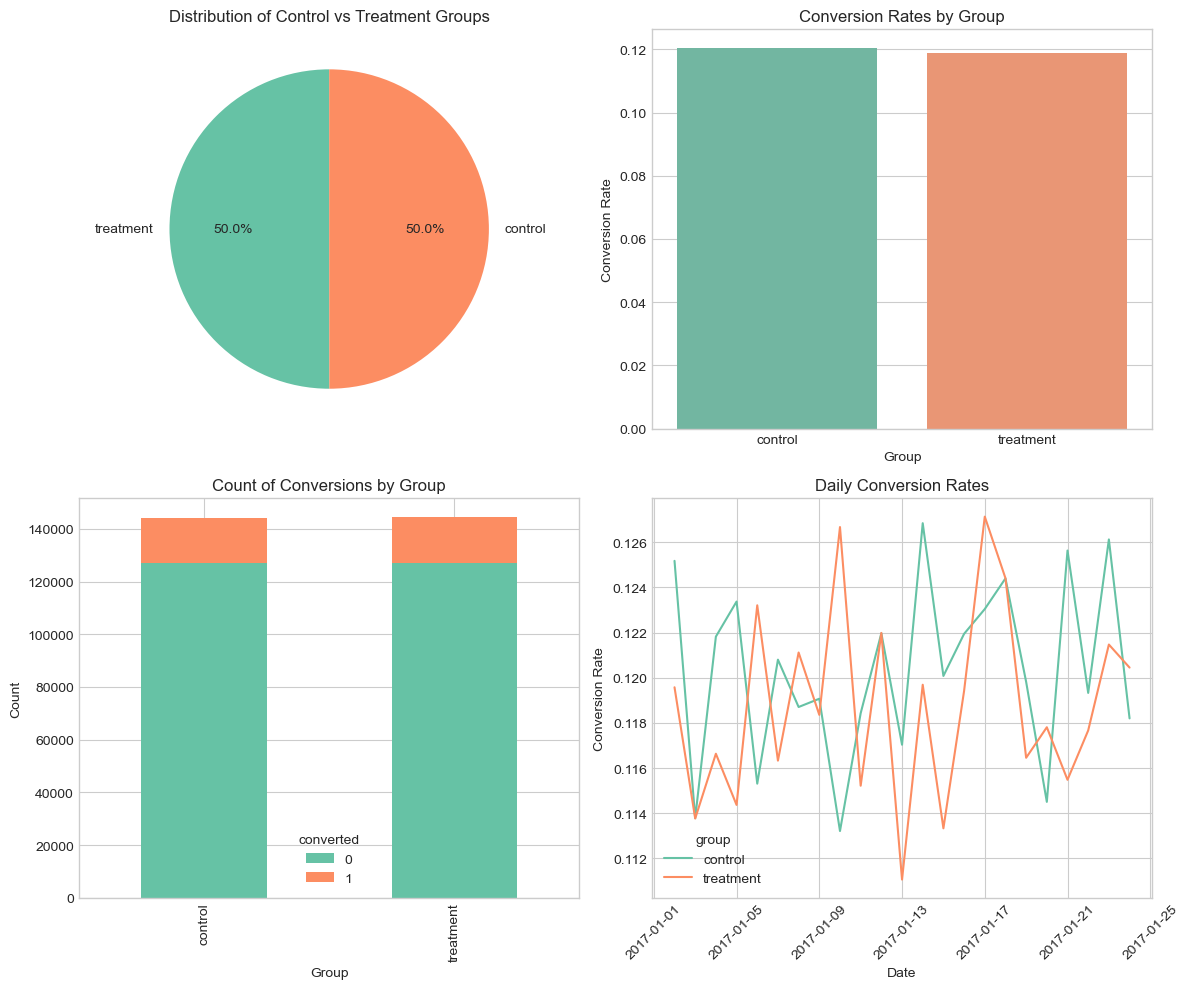

In [21]:
print("\nGroup distribution:")
group_counts = df['group'].value_counts()
print(group_counts)

# Conversion rates by group
print("\nConversion rates by group:")
conversion_rates = df.groupby('group')['converted'].agg(['mean', 'count', 'sum'])
conversion_rates.columns = ['conversion_rate', 'total_visitors', 'conversions']
print(conversion_rates)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Group distribution
axes[0, 0].pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution of Control vs Treatment Groups')

# 2. Conversion rates by group
sns.barplot(x=conversion_rates.index, y=conversion_rates['conversion_rate'], ax=axes[0, 1])
axes[0, 1].set_title('Conversion Rates by Group')
axes[0, 1].set_ylabel('Conversion Rate')
axes[0, 1].set_xlabel('Group')

# 3. Count of conversions by group
conversion_counts = df.groupby(['group', 'converted']).size().unstack()
conversion_counts.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Count of Conversions by Group')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Group')

# 4. Daily trends (if timestamp is properly parsed)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
daily_conversions = df.groupby(['date', 'group'])['converted'].mean().unstack()
daily_conversions.plot(ax=axes[1, 1])
axes[1, 1].set_title('Daily Conversion Rates')
axes[1, 1].set_ylabel('Conversion Rate')
axes[1, 1].set_xlabel('Date')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#  A/B Testing - Statistical Analysis

In [24]:
# Separate control and treatment groups
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

# Calculate conversion rates
control_conversion_rate = control_group['converted'].mean()
treatment_conversion_rate = treatment_group['converted'].mean()

# Calculate number of successes and trials
control_successes = control_group['converted'].sum()
control_trials = len(control_group)
treatment_successes = treatment_group['converted'].sum()
treatment_trials = len(treatment_group)

print(f"Control Group:")
print(f"  Sample size: {control_trials}")
print(f"  Conversions: {control_successes}")
print(f"  Conversion rate: {control_conversion_rate:.4f} ({control_conversion_rate*100:.2f}%)")

print(f"\nTreatment Group (New Page):")
print(f"  Sample size: {treatment_trials}")
print(f"  Conversions: {treatment_successes}")
print(f"  Conversion rate: {treatment_conversion_rate:.4f} ({treatment_conversion_rate*100:.2f}%)")

print(f"\nAbsolute difference: {treatment_conversion_rate - control_conversion_rate:.4f}")
print(f"Relative improvement: {((treatment_conversion_rate - control_conversion_rate) / control_conversion_rate)*100:.2f}%")



Control Group:
  Sample size: 144226
  Conversions: 17349
  Conversion rate: 0.1203 (12.03%)

Treatment Group (New Page):
  Sample size: 144314
  Conversions: 17134
  Conversion rate: 0.1187 (11.87%)

Absolute difference: -0.0016
Relative improvement: -1.30%


# Perform Z-test for proportions




In [25]:
# Perform two-proportion z-test
successes = [control_successes, treatment_successes]
trials = [control_trials, treatment_trials]

z_stat, p_value = proportions_ztest(successes, trials)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Calculate confidence intervals
conf_int_control = proportion_confint(control_successes, control_trials, alpha=0.05, method='normal')
conf_int_treatment = proportion_confint(treatment_successes, treatment_trials, alpha=0.05, method='normal')

print(f"\n95% Confidence Intervals:")
print(f"Control group: ({conf_int_control[0]:.4f}, {conf_int_control[1]:.4f})")
print(f"Treatment group: ({conf_int_treatment[0]:.4f}, {conf_int_treatment[1]:.4f})")


Z-statistic: 1.2942
P-value: 0.1956

95% Confidence Intervals:
Control group: (0.1186, 0.1220)
Treatment group: (0.1171, 0.1204)


# Calculate statistical power


In [26]:
effect_size = sms.proportion_effectsize(control_conversion_rate, treatment_conversion_rate)

# Calculate required sample size for desired power
required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

print(f"Effect size: {effect_size:.4f}")
print(f"Required sample size per group for 80% power: {int(np.ceil(required_n))}")
print(f"Actual sample size per group: Control={control_trials}, Treatment={treatment_trials}")

Effect size: 0.0048
Required sample size per group for 80% power: 676008
Actual sample size per group: Control=144226, Treatment=144314


# Bayesian A/B Testing (Alternative approach)

In [27]:
# Simple Bayesian estimation
# Prior: Beta(1, 1) which is uniform
alpha_prior = 1
beta_prior = 1

# Posterior distributions
alpha_control = alpha_prior + control_successes
beta_control = beta_prior + (control_trials - control_successes)

alpha_treatment = alpha_prior + treatment_successes
beta_treatment = beta_prior + (treatment_trials - treatment_successes)

print("Posterior distributions (Beta):")
print(f"Control: Beta({alpha_control}, {beta_control})")
print(f"Treatment: Beta({alpha_treatment}, {beta_treatment})")

# Probability that treatment is better than control
from scipy.stats import beta
prob_treatment_better = 1 - beta(alpha_treatment, beta_treatment).cdf(control_conversion_rate)
print(f"\nProbability that treatment is better than control: {prob_treatment_better:.4f}")


Posterior distributions (Beta):
Control: Beta(17350, 126878)
Treatment: Beta(17135, 127181)

Probability that treatment is better than control: 0.0340


# Results Interpretation

In [28]:
alpha = 0.05  # Significance level

if p_value < alpha:
    print("✅ RESULT: Statistically Significant Difference Found!")
    print(f"   The new page (treatment) shows a statistically significant difference from the old page.")
    print(f"   P-value ({p_value:.4f}) < α ({alpha})")
    
    if treatment_conversion_rate > control_conversion_rate:
        print("   🎯 The new page has HIGHER conversion rate!")
        print(f"   Recommendation: IMPLEMENT the new page.")
    else:
        print("   ⚠️ The new page has LOWER conversion rate!")
        print(f"   Recommendation: DO NOT implement the new page.")
else:
    print("❌ RESULT: No Statistically Significant Difference Found")
    print(f"   P-value ({p_value:.4f}) ≥ α ({alpha})")
    print(f"   The new page does not show a statistically significant difference from the old page.")
    print(f"   Recommendation: Further testing may be needed with larger sample size.")

print(f"\nPractical Significance:")
print(f"   Absolute difference: {(treatment_conversion_rate - control_conversion_rate)*100:.2f}%")
print(f"   Relative improvement: {((treatment_conversion_rate - control_conversion_rate) / control_conversion_rate)*100:.2f}%")


❌ RESULT: No Statistically Significant Difference Found
   P-value (0.1956) ≥ α (0.05)
   The new page does not show a statistically significant difference from the old page.
   Recommendation: Further testing may be needed with larger sample size.

Practical Significance:
   Absolute difference: -0.16%
   Relative improvement: -1.30%


# Calculate Confidence Interval for the Difference

In [30]:
# Calculate standard errors
se_control = np.sqrt(control_conversion_rate * (1 - control_conversion_rate) / control_trials)
se_treatment = np.sqrt(treatment_conversion_rate * (1 - treatment_conversion_rate) / treatment_trials)

# Calculate difference and its standard error
diff = treatment_conversion_rate - control_conversion_rate
se_diff = np.sqrt(se_control**2 + se_treatment**2)

# 95% confidence interval for the difference
ci_lower = diff - 1.96 * se_diff
ci_upper = diff + 1.96 * se_diff

print(f"Difference in conversion rates (Treatment - Control): {diff:.4f}")
print(f"95% Confidence Interval for the difference: ({ci_lower:.4f}, {ci_upper:.4f})")

if ci_lower > 0 and ci_upper > 0:
    print("   The entire confidence interval is above 0.")
    print("   This suggests the treatment is definitely better than control.")
elif ci_lower < 0 and ci_upper < 0:
    print("   The entire confidence interval is below 0.")
    print("   This suggests the treatment is definitely worse than control.")
else:
    print("   The confidence interval includes 0.")
    print("   This suggests no clear winner (or more data is needed).")


Difference in conversion rates (Treatment - Control): -0.0016
95% Confidence Interval for the difference: (-0.0039, 0.0008)
   The confidence interval includes 0.
   This suggests no clear winner (or more data is needed).


# Additional Visualizations

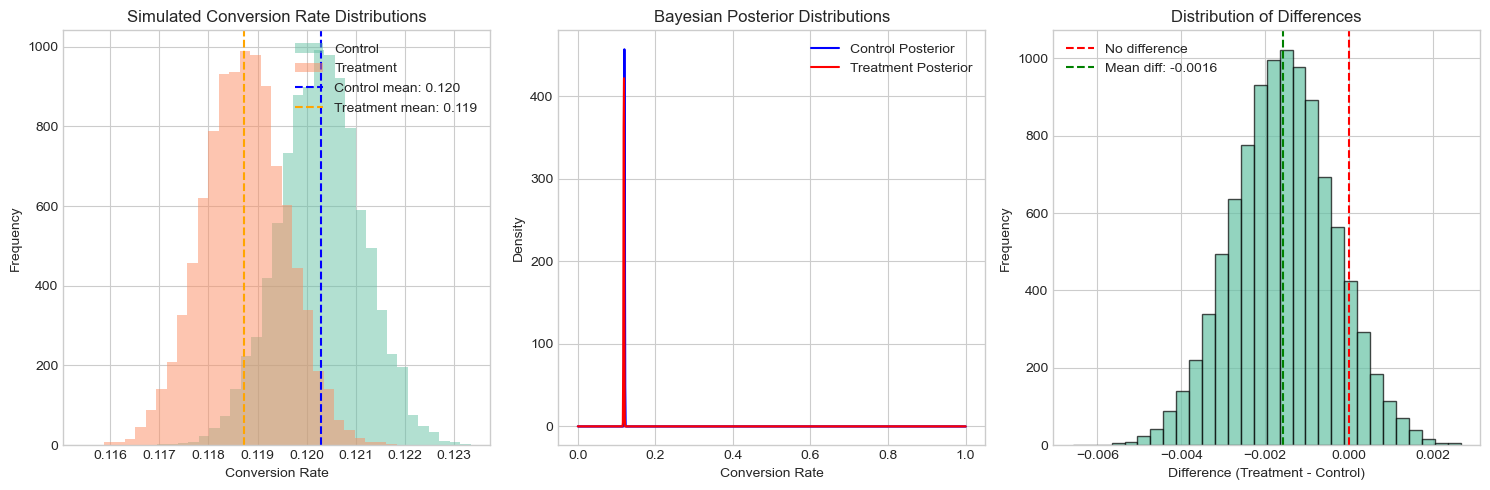

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Distribution of conversion rates (simulation)
np.random.seed(42)
control_simulated = np.random.binomial(control_trials, control_conversion_rate, 10000) / control_trials
treatment_simulated = np.random.binomial(treatment_trials, treatment_conversion_rate, 10000) / treatment_trials

axes[0].hist(control_simulated, alpha=0.5, label='Control', bins=30)
axes[0].hist(treatment_simulated, alpha=0.5, label='Treatment', bins=30)
axes[0].axvline(control_conversion_rate, color='blue', linestyle='--', label=f'Control mean: {control_conversion_rate:.3f}')
axes[0].axvline(treatment_conversion_rate, color='orange', linestyle='--', label=f'Treatment mean: {treatment_conversion_rate:.3f}')
axes[0].set_xlabel('Conversion Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Simulated Conversion Rate Distributions')
axes[0].legend()

# 2. Bayesian posterior distributions
x = np.linspace(0, 1, 1000)
axes[1].plot(x, beta.pdf(x, alpha_control, beta_control), 'b-', label='Control Posterior')
axes[1].plot(x, beta.pdf(x, alpha_treatment, beta_treatment), 'r-', label='Treatment Posterior')
axes[1].fill_between(x, 0, beta.pdf(x, alpha_control, beta_control), alpha=0.3, color='blue')
axes[1].fill_between(x, 0, beta.pdf(x, alpha_treatment, beta_treatment), alpha=0.3, color='red')
axes[1].set_xlabel('Conversion Rate')
axes[1].set_ylabel('Density')
axes[1].set_title('Bayesian Posterior Distributions')
axes[1].legend()

# 3. Difference distribution
diff_simulated = treatment_simulated - control_simulated
axes[2].hist(diff_simulated, bins=30, alpha=0.7, edgecolor='black')
axes[2].axvline(0, color='red', linestyle='--', label='No difference')
axes[2].axvline(np.mean(diff_simulated), color='green', linestyle='--', 
               label=f'Mean diff: {np.mean(diff_simulated):.4f}')
axes[2].set_xlabel('Difference (Treatment - Control)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Differences')
axes[2].legend()

plt.tight_layout()
plt.show()


# Summary Report

In [33]:
print(f"\n📊 TEST PARAMETERS:")
print(f"   Significance level (α): {alpha}")
print(f"   Test type: Two-proportion Z-test")
print(f"   Test direction: Two-tailed")

print(f"\n📈 SAMPLE SIZES:")
print(f"   Control group (old page): {control_trials} users")
print(f"   Treatment group (new page): {treatment_trials} users")
print(f"   Total sample size: {control_trials + treatment_trials} users")

print(f"\n🎯 CONVERSION RATES:")
print(f"   Control (old page): {control_conversion_rate:.4f} ({control_conversion_rate*100:.2f}%)")
print(f"   Treatment (new page): {treatment_conversion_rate:.4f} ({treatment_conversion_rate*100:.2f}%)")

print(f"\n📉 DIFFERENCE METRICS:")
print(f"   Absolute difference: {(treatment_conversion_rate - control_conversion_rate):.4f}")
print(f"   Relative difference: {((treatment_conversion_rate - control_conversion_rate)/control_conversion_rate)*100:.2f}%")

print(f"\n🔬 STATISTICAL RESULTS:")
print(f"   Z-statistic: {z_stat:.4f}")
print(f"   P-value: {p_value:.4f}")
print(f"   95% CI for difference: ({ci_lower:.4f}, {ci_upper:.4f})")

print(f"\n💡 RECOMMENDATION:")
if p_value < alpha:
    if treatment_conversion_rate > control_conversion_rate:
        print("   ✅ IMPLEMENT the new page (statistically significant improvement)")
    else:
        print("   ❌ DO NOT implement the new page (statistically significant decline)")
else:
    print("   ⚠️ No clear winner. Consider:")
    print("      - Running the test longer")
    print("      - Increasing sample size")
    print("      - Checking for other metrics (engagement, time on page, etc.)")



📊 TEST PARAMETERS:
   Significance level (α): 0.05
   Test type: Two-proportion Z-test
   Test direction: Two-tailed

📈 SAMPLE SIZES:
   Control group (old page): 144226 users
   Treatment group (new page): 144314 users
   Total sample size: 288540 users

🎯 CONVERSION RATES:
   Control (old page): 0.1203 (12.03%)
   Treatment (new page): 0.1187 (11.87%)

📉 DIFFERENCE METRICS:
   Absolute difference: -0.0016
   Relative difference: -1.30%

🔬 STATISTICAL RESULTS:
   Z-statistic: 1.2942
   P-value: 0.1956
   95% CI for difference: (-0.0039, 0.0008)

💡 RECOMMENDATION:
   ⚠️ No clear winner. Consider:
      - Running the test longer
      - Increasing sample size
      - Checking for other metrics (engagement, time on page, etc.)


# Lets do this more intresting with merging the other data set 

In [39]:
df=pd.read_csv('/Downloads/countries/countries.csv')
df.head()
df=pd.read_csv('/Downloads/ab_data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Merge the datasets

In [44]:
import pandas as pd

# Load both datasets with proper variable names
countries_df = pd.read_csv('/Downloads/countries/countries.csv')
ab_data_df = pd.read_csv('/Downloads/ab_data/ab_data.csv')

# Now you can use these variables
print("Countries data shape:", countries_df.shape)
print("A/B data shape:", ab_data_df.shape)

Countries data shape: (290584, 2)
A/B data shape: (294478, 5)


In [46]:
# Define ab_data_df if you have it loaded as something else
# Check what you actually have:
print(type(df))  # Check what df contains

# If df is your A/B data, rename it:
ab_data_df = df.copy()  # Now you have ab_data_df

# Then reload countries data
countries_df = pd.read_csv('/Downloads/countries/countries.csv')

<class 'pandas.core.frame.DataFrame'>


In [48]:
# Try this - use the variable names from your merge attempt
# First make sure you have the data loaded with these names:
ab_data = pd.read_csv('/Downloads/ab_data/ab_data.csv')
countries = pd.read_csv('/Downloads/countries/countries.csv')


try:
    merged_data = pd.merge(ab_data, countries, on='user_id', how='left')
    print("Merge successful!")
except KeyError as e:
    print(f"Error: {e}")
    print("'user_id' column doesn't exist in one or both DataFrames")

Merge successful!


In [52]:
ab_data = pd.read_csv('/Downloads/ab_data/ab_data.csv')
print(f"A/B Data shape: {ab_data.shape}")
print("A/B Data columns:", ab_data.columns.tolist())


A/B Data shape: (294478, 5)
A/B Data columns: ['user_id', 'timestamp', 'group', 'landing_page', 'converted']


In [53]:
countries = pd.read_csv('/Downloads/countries/countries.csv')
print(f"\nCountries Data shape: {countries.shape}")
print("Countries Data columns:", countries.columns.tolist())


Countries Data shape: (290584, 2)
Countries Data columns: ['user_id', 'country']


In [54]:
print("\nA/B Data (first 5 rows):")
print(ab_data.head())
print("\nCountries Data (first 5 rows):")
print(countries.head())


A/B Data (first 5 rows):
   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

Countries Data (first 5 rows):
   user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK


In [55]:
print("\n\nStep 2: Data Quality Check")
print("=" * 50)

# Check for duplicates
print(f"A/B Data - Duplicate user IDs: {ab_data['user_id'].duplicated().sum()}")
print(f"Countries Data - Duplicate user IDs: {countries['user_id'].duplicated().sum()}")

# Check for missing values
print("\nMissing values in A/B Data:")
print(ab_data.isnull().sum())
print("\nMissing values in Countries Data:")
print(countries.isnull().sum())

# Check unique values
print(f"\nUnique groups in A/B Data: {ab_data['group'].unique()}")
print(f"Unique landing pages: {ab_data['landing_page'].unique()}")
print(f"Unique countries: {countries['country'].nunique() if 'country' in countries.columns else 'N/A'}")



Step 2: Data Quality Check
A/B Data - Duplicate user IDs: 3894
Countries Data - Duplicate user IDs: 0

Missing values in A/B Data:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Missing values in Countries Data:
user_id    0
country    0
dtype: int64

Unique groups in A/B Data: ['control' 'treatment']
Unique landing pages: ['old_page' 'new_page']
Unique countries: 3


In [56]:
print("\n\nStep 3: Merging Datasets")
print("=" * 50)

# Check common columns for merging
common_cols = set(ab_data.columns).intersection(set(countries.columns))
print(f"Common columns for merging: {common_cols}")

# Assuming 'user_id' is the common column (adjust if different)
if 'user_id' in common_cols:
    # Merge the datasets
    merged_data = pd.merge(ab_data, countries, on='user_id', how='left')
    print("✓ Merge successful!")
    print(f"Merged data shape: {merged_data.shape}")
    print(f"\nMerged data columns: {merged_data.columns.tolist()}")
    
    # Display first few rows of merged data
    print("\nMerged Data (first 10 rows):")
    print(merged_data.head(10))
else:
    print("✗ No common column found for merging. Checking alternative merge options...")
    # If no common column, we might need to merge differently
    print("\nA/B Data columns:", ab_data.columns.tolist())
    print("Countries Data columns:", countries.columns.tolist())
    
    # Try to find potential merge keys
    print("\nLooking for potential merge columns...")
    ab_str_cols = ab_data.select_dtypes(include=['object']).columns
    country_str_cols = countries.select_dtypes(include=['object']).columns
    print(f"Text columns in A/B data: {list(ab_str_cols)}")
    print(f"Text columns in Countries data: {list(country_str_cols)}")
    
    # Exit if no common column found
    raise ValueError("No common column found for merging. Please check your datasets.")

# Step 5: Check merge quality
print("\n\nStep 4: Merge Quality Check")
print("=" * 50)

# Check how many users got country information
if 'country' in merged_data.columns:
    users_with_country = merged_data['country'].notna().sum()
    total_users = len(merged_data)
    print(f"Users with country info: {users_with_country}/{total_users} ({users_with_country/total_users*100:.2f}%)")
    
    # Check unique countries
    unique_countries = merged_data['country'].nunique()
    print(f"Unique countries: {unique_countries}")
    print("\nCountry distribution:")
    print(merged_data['country'].value_counts().head(10))
    
    # Check for users without country info
    if users_with_country < total_users:
        print(f"\nUsers without country info: {total_users - users_with_country}")
        print("Sample of users without country info:")
        print(merged_data[merged_data['country'].isna()].head())

# Check group distribution
print("\nGroup distribution in merged data:")
group_dist = merged_data['group'].value_counts(normalize=True)
print(group_dist)




Step 3: Merging Datasets
Common columns for merging: {'user_id'}
✓ Merge successful!
Merged data shape: (294478, 6)

Merged data columns: ['user_id', 'timestamp', 'group', 'landing_page', 'converted', 'country']

Merged Data (first 10 rows):
   user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   
5   936923  2017-01-10 15:20:49.083499    control     old_page          0   
6   679687  2017-01-19 03:26:46.940749  treatment     new_page          1   
7   719014  2017-01-17 01:48:29.539573    control     old_page          0   
8   817355  2017-01-04 17:58:08.979471  treatment     new_page 

# Exploratory Data Analysis

In [57]:
print("Basic Statistics:")
print(f"Total users: {len(merged_data)}")
print(f"Control group: {len(merged_data[merged_data['group'] == 'control'])}")
print(f"Treatment group: {len(merged_data[merged_data['group'] == 'treatment'])}")

if 'converted' in merged_data.columns:
    overall_conversion = merged_data['converted'].mean()
    print(f"Overall conversion rate: {overall_conversion:.4f} ({overall_conversion*100:.2f}%)")

# 6.2 Conversion rates by group
print("\nConversion rates by group:")
if 'converted' in merged_data.columns:
    conversion_by_group = merged_data.groupby('group')['converted'].agg(['mean', 'count', 'sum'])
    conversion_by_group.columns = ['conversion_rate', 'total_users', 'conversions']
    print(conversion_by_group)

# 6.3 Country analysis
if 'country' in merged_data.columns:
    print("\nTop 10 countries by user count:")
    top_countries = merged_data['country'].value_counts().head(10)
    print(top_countries)
    
    print("\nConversion rates by country (top 10 by sample size):")
    if 'converted' in merged_data.columns:
        # Get countries with reasonable sample size
        country_counts = merged_data['country'].value_counts()
        countries_with_data = country_counts[country_counts >= 10].index
        
        if len(countries_with_data) > 0:
            country_stats = merged_data[merged_data['country'].isin(countries_with_data)]
            country_conversion = country_stats.groupby('country')['converted'].agg(['mean', 'count'])
            country_conversion.columns = ['conversion_rate', 'sample_size']
            print(country_conversion.sort_values('sample_size', ascending=False).head(10))


Basic Statistics:
Total users: 294478
Control group: 147202
Treatment group: 147276
Overall conversion rate: 0.1197 (11.97%)

Conversion rates by group:
           conversion_rate  total_users  conversions
group                                               
control           0.120399       147202        17723
treatment         0.118920       147276        17514

Top 10 countries by user count:
US    206364
UK     73419
CA     14695
Name: country, dtype: int64

Conversion rates by country (top 10 by sample size):
         conversion_rate  sample_size
country                              
US              0.119599       206364
UK              0.120582        73419
CA              0.115890        14695


# Visualizations

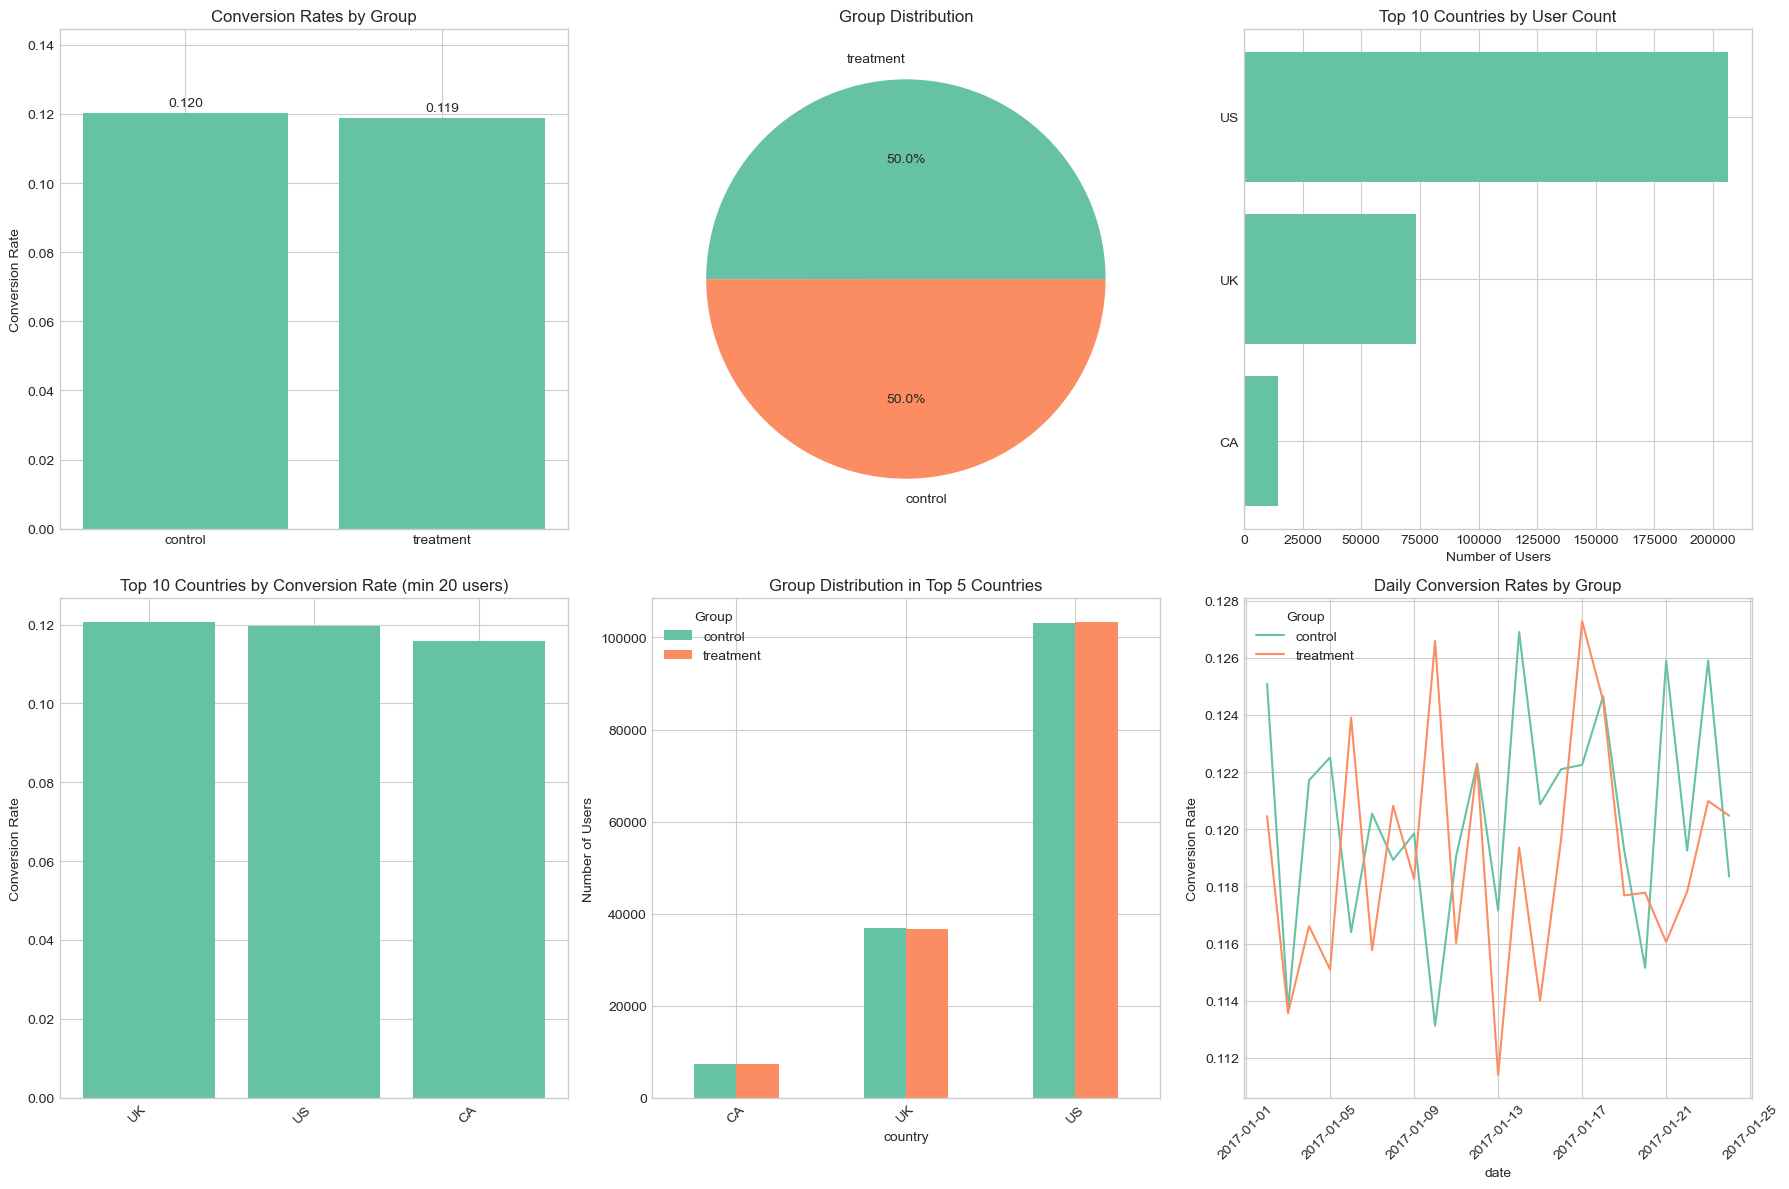

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Conversion rates by group
if 'converted' in merged_data.columns:
    conversion_rates = merged_data.groupby('group')['converted'].mean()
    axes[0, 0].bar(conversion_rates.index, conversion_rates.values)
    axes[0, 0].set_title('Conversion Rates by Group')
    axes[0, 0].set_ylabel('Conversion Rate')
    axes[0, 0].set_ylim(0, max(conversion_rates.values) * 1.2)
    for i, v in enumerate(conversion_rates.values):
        axes[0, 0].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')

# 2. Group distribution
group_counts = merged_data['group'].value_counts()
axes[0, 1].pie(group_counts.values, labels=group_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Group Distribution')

# 3. Country distribution (top 10)
if 'country' in merged_data.columns:
    top_countries = merged_data['country'].value_counts().head(10)
    axes[0, 2].barh(range(len(top_countries)), top_countries.values)
    axes[0, 2].set_yticks(range(len(top_countries)))
    axes[0, 2].set_yticklabels(top_countries.index)
    axes[0, 2].set_title('Top 10 Countries by User Count')
    axes[0, 2].set_xlabel('Number of Users')
    axes[0, 2].invert_yaxis()

# 4. Conversion by country (if enough data)
if 'country' in merged_data.columns and 'converted' in merged_data.columns:
    # Get countries with at least 20 users
    country_sample_sizes = merged_data.groupby('country').size()
    valid_countries = country_sample_sizes[country_sample_sizes >= 20].index
    
    if len(valid_countries) > 0:
        country_conversion = merged_data[merged_data['country'].isin(valid_countries)]
        conversion_by_country = country_conversion.groupby('country')['converted'].mean().sort_values(ascending=False).head(10)
        
        axes[1, 0].bar(range(len(conversion_by_country)), conversion_by_country.values)
        axes[1, 0].set_xticks(range(len(conversion_by_country)))
        axes[1, 0].set_xticklabels(conversion_by_country.index, rotation=45, ha='right')
        axes[1, 0].set_title('Top 10 Countries by Conversion Rate (min 20 users)')
        axes[1, 0].set_ylabel('Conversion Rate')

# 5. Group distribution by country (top 5 countries)
if 'country' in merged_data.columns:
    top_5_countries = merged_data['country'].value_counts().head(5).index
    top_5_data = merged_data[merged_data['country'].isin(top_5_countries)]
    
    if len(top_5_data) > 0:
        group_by_country = pd.crosstab(top_5_data['country'], top_5_data['group'])
        group_by_country.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Group Distribution in Top 5 Countries')
        axes[1, 1].set_ylabel('Number of Users')
        axes[1, 1].legend(title='Group')
        axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Time series of conversions (if timestamp exists)
if 'timestamp' in merged_data.columns and 'converted' in merged_data.columns:
    merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
    merged_data['date'] = merged_data['timestamp'].dt.date
    
    daily_conversions = merged_data.groupby(['date', 'group'])['converted'].mean().unstack()
    daily_conversions.plot(ax=axes[1, 2])
    axes[1, 2].set_title('Daily Conversion Rates by Group')
    axes[1, 2].set_ylabel('Conversion Rate')
    axes[1, 2].legend(title='Group')
    axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# A/B Testing Analysis

In [59]:
if 'converted' in merged_data.columns:
    # Overall A/B test
    control_data = merged_data[merged_data['group'] == 'control']
    treatment_data = merged_data[merged_data['group'] == 'treatment']
    
    control_conversion = control_data['converted'].mean()
    treatment_conversion = treatment_data['converted'].mean()
    
    control_success = control_data['converted'].sum()
    control_total = len(control_data)
    treatment_success = treatment_data['converted'].sum()
    treatment_total = len(treatment_data)
    
    print("Overall A/B Test Results:")
    print(f"Control group (old page):")
    print(f"  Users: {control_total}")
    print(f"  Conversions: {control_success}")
    print(f"  Conversion rate: {control_conversion:.4f} ({control_conversion*100:.2f}%)")
    
    print(f"\nTreatment group (new page):")
    print(f"  Users: {treatment_total}")
    print(f"  Conversions: {treatment_success}")
    print(f"  Conversion rate: {treatment_conversion:.4f} ({treatment_conversion*100:.2f}%)")
    
    print(f"\nDifference: {treatment_conversion - control_conversion:.4f}")
    print(f"Relative improvement: {(treatment_conversion - control_conversion)/control_conversion*100:.2f}%")
    
    # Perform statistical test
    successes = [control_success, treatment_success]
    trials = [control_total, treatment_total]
    
    try:
        z_stat, p_value = proportions_ztest(successes, trials, alternative='two-sided')
        print(f"\nStatistical Test:")
        print(f"  Z-statistic: {z_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Significant at 95% confidence: {'YES' if p_value < 0.05 else 'NO'}")
        
        # Calculate confidence intervals
        ci_control = proportion_confint(control_success, control_total, alpha=0.05, method='wilson')
        ci_treatment = proportion_confint(treatment_success, treatment_total, alpha=0.05, method='wilson')
        
        print(f"\n95% Confidence Intervals:")
        print(f"  Control: [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
        print(f"  Treatment: [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
        
    except Exception as e:
        print(f"Error in statistical test: {e}")


Overall A/B Test Results:
Control group (old page):
  Users: 147202
  Conversions: 17723
  Conversion rate: 0.1204 (12.04%)

Treatment group (new page):
  Users: 147276
  Conversions: 17514
  Conversion rate: 0.1189 (11.89%)

Difference: -0.0015
Relative improvement: -1.23%

Statistical Test:
  Z-statistic: 1.2369
  P-value: 0.2161
  Significant at 95% confidence: NO

95% Confidence Intervals:
  Control: [0.1187, 0.1221]
  Treatment: [0.1173, 0.1206]


# Country-Specific A/B Tests

In [60]:
if 'country' in merged_data.columns and 'converted' in merged_data.columns:
    # Function to run A/B test for a specific country
    def run_country_ab_test(country_name, data):
        country_data = data[data['country'] == country_name]
        if len(country_data) < 20:  # Minimum sample size
            return None
        
        control = country_data[country_data['group'] == 'control']
        treatment = country_data[country_data['group'] == 'treatment']
        
        if len(control) == 0 or len(treatment) == 0:
            return None
        
        control_conv = control['converted'].mean()
        treatment_conv = treatment['converted'].mean()
        
        control_success = control['converted'].sum()
        control_total = len(control)
        treatment_success = treatment['converted'].sum()
        treatment_total = len(treatment)
        
        # Perform statistical test
        successes = [control_success, treatment_success]
        trials = [control_total, treatment_total]
        
        try:
            z_stat, p_value = proportions_ztest(successes, trials, alternative='two-sided')
        except:
            z_stat, p_value = np.nan, np.nan
        
        return {
            'country': country_name,
            'control_conversion': control_conv,
            'treatment_conversion': treatment_conv,
            'difference': treatment_conv - control_conv,
            'relative_improvement': ((treatment_conv - control_conv) / control_conv * 100) if control_conv > 0 else np.nan,
            'control_sample': control_total,
            'treatment_sample': treatment_total,
            'total_sample': control_total + treatment_total,
            'z_statistic': z_stat,
            'p_value': p_value,
            'significant': p_value < 0.05 if not pd.isna(p_value) else False
        }
    
    # Run tests for all countries with sufficient data
    country_results = []
    for country in merged_data['country'].dropna().unique():
        result = run_country_ab_test(country, merged_data)
        if result:
            country_results.append(result)
    
    if country_results:
        country_results_df = pd.DataFrame(country_results)
        country_results_df = country_results_df.sort_values('total_sample', ascending=False)
        
        print(f"A/B Tests completed for {len(country_results_df)} countries")
        print("\nTop 10 countries by sample size:")
        print(country_results_df[['country', 'control_conversion', 'treatment_conversion', 
                                 'difference', 'p_value', 'significant', 'total_sample']].head(10).to_string())
        
        # Categorize results
        effective_countries = country_results_df[
            (country_results_df['significant'] == True) & 
            (country_results_df['difference'] > 0)
        ]
        
        ineffective_countries = country_results_df[
            (country_results_df['significant'] == True) & 
            (country_results_df['difference'] < 0)
        ]
        
        neutral_countries = country_results_df[
            (country_results_df['significant'] == False)
        ]
        
        print(f"\nSummary:")
        print(f"  Countries where new page is effective: {len(effective_countries)}")
        print(f"  Countries where new page is ineffective: {len(ineffective_countries)}")
        print(f"  Countries with inconclusive results: {len(neutral_countries)}")
        
        if len(effective_countries) > 0:
            print(f"\n✅ Best performing countries (new page works better):")
            for _, row in effective_countries.nlargest(5, 'difference').iterrows():
                print(f"  {row['country']}: +{row['difference']*100:.1f}% (p={row['p_value']:.3f})")
        
        if len(ineffective_countries) > 0:
            print(f"\n❌ Worst performing countries (old page works better):")
            for _, row in ineffective_countries.nsmallest(5, 'difference').iterrows():
                print(f"  {row['country']}: {row['difference']*100:.1f}% (p={row['p_value']:.3f})")


A/B Tests completed for 3 countries

Top 10 countries by sample size:
  country  control_conversion  treatment_conversion  difference   p_value  significant  total_sample
0      US            0.120552              0.118649   -0.001904  0.182696        False        206364
2      UK            0.120192              0.120974    0.000782  0.744866        False         73419
1      CA            0.119282              0.112539   -0.006744  0.201638        False         14695

Summary:
  Countries where new page is effective: 0
  Countries where new page is ineffective: 0
  Countries with inconclusive results: 3
